In [1]:
#Ryan Shin: sungjin7127@gmail.com
#Date: 160927
#Obj: find the best model for emotion recogntion

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#%matplotlib inline
print ("Packages loaded")

#Load data
cwd = os.getcwd()
loadpath = cwd + "/dataset/data_gray.npz"
l = np.load(loadpath)

#Check what's included
print (l.files)

# Parse data
trainimg = l['trainimg']
trainlabel = l['trainlabel']
testimg = l['testimg']
testlabel = l['testlabel']
imgsize = l['imgsize']
#use_gray = l['use_gray']
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]
print ("%d train images loaded" % (ntrain))
print ("%d test images loaded" % (ntest))
print ("%d dimensional input" % (dim))
print ("Image size is %s" % (imgsize))
print ("%d classes" % (nclass))

Packages loaded
['trainlabel', 'trainimg', 'imgsize', 'testimg', 'testlabel']
2614 train images loaded
1743 test images loaded
4096 dimensional input
Image size is [64 64]
8 classes


In [2]:
a = trainimg[5]
a2 = a.reshape(28,28)
a2.shape

ValueError: total size of new array must be unchanged

<function matplotlib.pyplot.show>

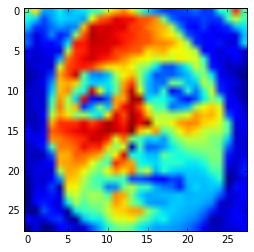

In [10]:
%matplotlib inline
plt.imshow(a2)
plt.show

In [3]:
device_type = "/cpu:0"

In [6]:
with tf.device(device_type): # <= This is optional
    n_input  = 48 * 48
    n_output = 8
    weights  = {
        'wc1': tf.Variable(tf.random_normal([3, 3, 1, 96], stddev=0.1)),
        'wd1': tf.Variable(tf.random_normal([24*24*96, n_output], stddev=0.1))
    }
    biases   = {
        'bc1': tf.Variable(tf.random_normal([96], stddev=0.1)),
        'bd1': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    def conv_simple(_input, _w, _b):
        # Reshape input
        _input_r = tf.reshape(_input, shape=[-1, 48, 48, 1])
        # Convolution
        _conv1 = tf.nn.conv2d(_input_r, _w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
        # Add-bias
        _conv2 = tf.nn.bias_add(_conv1, _b['bc1'])
        # Pass ReLu
        _conv3 = tf.nn.relu(_conv2)
        # Max-pooling
        _pool  = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        # Vectorize
        _dense = tf.reshape(_pool, [-1, _w['wd1'].get_shape().as_list()[0]])
        # Fully-connected layer
        _out = tf.add(tf.matmul(_dense, _w['wd1']), _b['bd1'])
        #output = tf.nn.softmax_cross_entropy_with_logits(_dense, weights['wd1'], biases['bd1'])
        # Return everything
        out = {
            'input_r': _input_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
            , 'pool': _pool, 'dense': _dense, 'out': _out
        }
        return out
print ("CNN ready")

CNN ready


In [7]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])
#keepratio = tf.placeholder(tf.float32)

# Parameters
learning_rate   = 0.001
training_epochs = 5
batch_size      = 100
display_step    = 1
# Functions! 
with tf.device(device_type): # <= This is optional
    _pred = conv_simple(x, weights, biases)['out']
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(_pred, y))
    optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    _corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1)) # Count corrects
    accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) # Accuracy
    init = tf.initialize_all_variables()
# Saver 
save_step = 1;
savedir = "./nets"
if not os.path.exists(savedir):
    os.makedirs(savedir)

saver = tf.train.Saver(max_to_keep=3) 
print ("Network Ready to Go!")

Network Ready to Go!


In [8]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [ ]:
if do_train == 1:
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(ntrain/batch_size)+1
        #total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            randidx = np.random.randint(ntrain, size=batch_size)
            batch_xs = trainimg[randidx, :]
            batch_ys = trainlabel[randidx, :]
            #batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training accuracy: %.3f" % (train_acc))
            test_acc = sess.run(accr, feed_dict={x: testimg, y: testlabel})
            print (" Test accuracy: %.3f" % (test_acc))

        # Save Net
        if epoch % save_step == 0:
            saver.save(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("Optimization Finished.")   

Epoch: 000/005 cost: 7.396405026
 Training accuracy: 0.200
 Test accuracy: 0.196
Epoch: 001/005 cost: 2.262025661
 Training accuracy: 0.340


In [35]:
do_train == 0

False

In [1]:
if do_train == 0:
    epoch = training_epochs-1
    saver.restore(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("NETWORK RESTORED")

NameError: name 'do_train' is not defined

In [38]:
graph = tf.Graph()

with graph.as_default():
    global_step = tf.Variable(0, name='global_step', trainable=False) 
    
with tf.Session(graph = graph) as session:
    ckpt = tf.train.get_checkpoint_state(savedir)
    saver.restore(sess, ckpt.model_checkpoint_path)
    start = global_step.eval()

FailedPreconditionError: Attempting to use uninitialized value global_step
	 [[Node: _send_global_step_0 = _Send[T=DT_INT32, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=2702633259668079466, tensor_name="global_step:0", _device="/job:localhost/replica:0/task:0/cpu:0"](global_step)]]

In [33]:
def save(checkpoint_file='hello.chk'):
    with tf.Session() as session:
        x = tf.Variable([42.0, 42.1, 42.3], name='x')
        y = tf.Variable([[1.0, 2.0], [3.0, 4.0]], name='y')
        not_saved = tf.Variable([-1, -2], name='not_saved')
        session.run(tf.initialize_all_variables())

        print(session.run(tf.all_variables()))
        saver = tf.train.Saver([x, y])
        saver.save(session, checkpoint_file)

def restore(checkpoint_file='hello.chk'):
    x = tf.Variable(-1.0, validate_shape=False, name='x')
    y = tf.Variable(-1.0, validate_shape=False, name='y')
    with tf.Session() as session:
        saver = tf.train.Saver()
        saver.restore(session, checkpoint_file)
        print(session.run(tf.all_variables()))
        
def reset():
    tf.reset_default_graph()

In [ ]:
saver.restore(session, )

In [28]:
if do_train == 0:
    epoch = training_epochs-1
    saver.restore(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("NETWORK RESTORED")

In [29]:
graph = tf.Graph()

with graph.as_default():
    global_step = tf.Variable(0, name='global_step', trainable=False) 
    
with tf.Session(graph = graph) as session:
    ckpt = tf.train.get_checkpoint_state(savedir)
    saver.restore(sess, ckpt.model_checkpoint_path)
    start = global_step.eval()


FailedPreconditionError: Attempting to use uninitialized value global_step
	 [[Node: _send_global_step_0 = _Send[T=DT_INT32, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=-5882995113061557318, tensor_name="global_step:0", _device="/job:localhost/replica:0/task:0/cpu:0"](global_step)]]

In [62]:
ckpt

model_checkpoint_path: "./nets/cnn_mnist_simple.ckpt-99"
all_model_checkpoint_paths: "./nets/cnn_mnist_simple.ckpt-97"
all_model_checkpoint_paths: "./nets/cnn_mnist_simple.ckpt-98"
all_model_checkpoint_paths: "./nets/cnn_mnist_simple.ckpt-99"

In [44]:
import cv2

REAL_DATA_PATH = './dataset/anger/0.jpg'
if (os.path.exists(REAL_DATA_PATH)):
    print('Full Filename : ' + REAL_DATA_PATH)
    img = cv2.imread(REAL_DATA_PATH)
    print(img.shape)
    if len(img.shape) == 2:
        print(img.shape)
        image = img.reshape([-1, IMAGE_SIZE, IMAGE_SIZE, 1])
        print(image.shape)
        print(image)
        image = (image.astype(float) - PIXEL_DEPTH / 2) / PIXEL_DEPTH
        print(image)
        image = np.float32(image)
        print(type(image))
        ckpt = tf.train.get_checkpoint_state(savedir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path) # restore all variables
            start = global_step.eval() # get last global_step
            global_step.assign(start).eval()
            logits = model(image, layer1_weights, layer1_biases, layer2_weights, 
            layer2_biases, layer3_weights, layer3_biases, layer4_weights, layer4_biases, 1.0, 1.0)
            #train_prediction = tf.argmax(logits, 1)
            train_prediction = session.run(tf.argmax(logits, 1))
            print('=====================================================')
            print(train_prediction)
            print('=====================================================')            
        else:
            print('saver data load Fail\t')    

Full Filename : ./dataset/anger/0.jpg
(350, 350, 3)


In [42]:
savedir2 = tf.train.get_checkpoint_state(savedir)
savedir2

model_checkpoint_path: "./nets/cnn_mnist_simple.ckpt-99"
all_model_checkpoint_paths: "./nets/cnn_mnist_simple.ckpt-97"
all_model_checkpoint_paths: "./nets/cnn_mnist_simple.ckpt-98"
all_model_checkpoint_paths: "./nets/cnn_mnist_simple.ckpt-99"

In [ ]:
if(os.path.exists(REAL_DATA_PATH)):
                print('Full Filename : ' + REAL_DATA_PATH)
                img = cv2.imread(REAL_DATA_PATH)
                img = facecrop(img)
                print(img.shape)
                if len(img.shape) == 2:
                    print(img.shape)
                    image = img.reshape([-1, IMAGE_SIZE, IMAGE_SIZE, 1])
                    print(image.shape)
                    print(image)
                    image = (image.astype(float) - PIXEL_DEPTH / 2) / PIXEL_DEPTH
                    print(image)
                    image = np.float32(image)
                    print(type(image))
                    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
                    if ckpt and ckpt.model_checkpoint_path:
                        saver.restore(session, ckpt.model_checkpoint_path) # restore all variables
                        start = global_step.eval() # get last global_step
                        global_step.assign(start).eval()
                        logits = model(image, layer1_weights, layer1_biases, layer2_weights, 
                        layer2_biases, layer3_weights, layer3_biases, layer4_weights, layer4_biases, 1.0, 1.0)
                        #train_prediction = tf.argmax(logits, 1)
                        train_prediction = session.run(tf.argmax(logits, 1))
                        print('=====================================================')
                        print(train_prediction)
                        print('=====================================================')            
                    else:
                        print('saver data load Fail\t')
                else:
                    print('Prediction \t Fail')               

In [20]:
with tf.device(device_type):
    conv_out = conv_simple(x, weights, biases)

input_r = sess.run(conv_out['input_r'], feed_dict={x: trainimg[0:1, :]})
conv1   = sess.run(conv_out['conv1'], feed_dict={x: trainimg[0:1, :]})
conv2   = sess.run(conv_out['conv2'], feed_dict={x: trainimg[0:1, :]})
conv3   = sess.run(conv_out['conv3'], feed_dict={x: trainimg[0:1, :]})
pool    = sess.run(conv_out['pool'], feed_dict={x: trainimg[0:1, :]})
dense   = sess.run(conv_out['dense'], feed_dict={x: trainimg[0:1, :]})
out     = sess.run(conv_out['out'], feed_dict={x: trainimg[0:1, :]})

0~7

paths = {"dataset/anger/", "dataset/contempt/", "dataset/disgust/", "dataset/fear",
        "dataset/happy/", "dataset/neutral/", "dataset/sadness/", "dataset/surprise/"}

Size of 'input_r' is (1, 28, 28, 1)
Label is 1


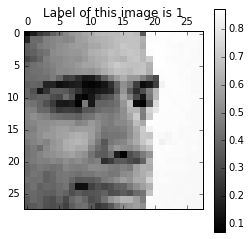

In [25]:
# Let's see 'input_r'
print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0, :])
print ("Label is %d" % (label))

# Plot ! 
plt.matshow(input_r[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label) + "")
plt.colorbar()
plt.show()
#Size of 'input_r' is (1, 28, 28